# Tidy Computations
<a href="https://colab.research.google.com/github/amakelov/mandala/blob/master/docs_source/blog/01_cf.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

In data-driven fields, such as machine learning, a lot of effort is spent
organizing *computational data* &mdash; results of running programs &mdash; so
that it can be analyzed and manipulated. This blog post introduces the
`ComputationFrame` (CF) data structure &mdash; a synthesis of computation graphs
and relational databases &mdash; which provides a natural and simple grammar of
operations to eliminate this effort.

The main benefit of CFs is that they give a single view of heterogeneous
computations that go beyond a fixed schema. They automatically represent in a
familiar and intuitive way constructs like conditional execution, feedback
loops, branching/merging pipelines, and aggregation/indexing using collections.
This view can be declaratively queried for relationships between any variables
in (literally) a single line of code, without leaving Python or writing in a
domain-specific language like SQL.

`ComputationFrame` is implemented as [part
of](https://amakelov.github.io/mandala/topics/03_cf/)
[mandala](https://github.com/amakelov/mandala), a Python library for experiment
tracking and incremental computation. All examples in this post are ran using
the library.


## So what's a `ComputationFrame`?
A `ComputationFrame` is a "generalized dataframe", where the set of columns is
replaced by a computation graph of variables and operations, and rows are
(possibly partial) executions of the graph.

### Minimal interesting example

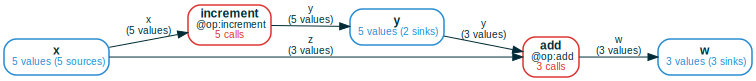

|    |   x | increment                                   |   y | add                                   |   w |
|---:|----:|:--------------------------------------------|----:|:--------------------------------------|----:|
|  0 |   1 | Call(increment, cid='948...', hid='6e2...') |   2 |                                       | nan |
|  1 |   4 | Call(increment, cid='928...', hid='adf...') |   5 | Call(add, cid='a54...', hid='deb...') |   9 |
|  2 |   3 | Call(increment, cid='9b4...', hid='df2...') |   4 |                                       | nan |
|  3 |   0 | Call(increment, cid='d47...', hid='230...') |   1 | Call(add, cid='89c...', hid='247...') |   1 |
|  4 |   2 | Call(increment, cid='bfb...', hid='5dd...') |   3 | Call(add, cid='a81...', hid='626...') |   5 |


In [1]:
# for Google Colab
try:
    import google.colab
    !pip install git+https://github.com/amakelov/mandala
except:
    pass

from mandala.imports import *

@op(output_names=['y'])
def increment(x): return x + 1

@op(output_names=['w'])
def add(y, z): return y + z

# compose the operations
with Storage() as storage:
    for x in range(5):
        y = increment(x)
        if x % 2 == 0:
            w = add(y=y, z=x)

# get a CF for just the `increment` operation 
cf = storage.cf(increment)
# expand the CF to include the `add` operation
cf = cf.expand_forward()
# draw the CF
cf.draw(verbose=True, orientation='LR')
# represent the CF to a dataframe
print(cf.df().to_markdown())

This small example illustrates the main components of the CF workflow:

- **run some computations**: we ran a computation by composing calls to some functions
(`increment` and `add`)
- **create a CF and add desired context to it**: we explored the computation by
starting from a CF for the calls to `increment` and *expanding it* forward to
add the subsequent calls to `add`
- **convert to a dataframe for downstream analysis**: we turned the expanded CF
into a dataframe, where the columns are the variables and operations in the
graph, and the rows are the executions of the graph &mdash; recorded as values
of variables and `Call` objects for operations. 

When a given computation is partial, missing values and calls are represented by
nulls in the dataframe, which allows for easy filtering and analysis.

### Precise definition
Concretely, a `ComputationFrame` consists of:

- a directed computation graph of operations and variables, where each operation
has multiple named inputs and outputs;
- a set of calls for each operation node, and a set of values for each variable
node.

The only (but key) property this data must satisfy is that, whenever
input/output variables are connected to an operation node `f`, the corresponding
input/output values of all calls in `f` are found in these variables.


## Case studies
To illustrate the versatility of `ComputationFrame`s and the grammar of
operations they support, let's now consider a fairly standard machine learning
pipeline as a running example. 

The goal will be to train several kinds of machine learning models on the moons
dataset from `sklearn`, and iterate on the pipeline by adding new models,
hyperparameters and feature selection methods. Here's some code to get us
started:

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
np.random.seed(42)

@op(output_names=["X", "y"])
def get_data():
    return make_moons(n_samples=1000, noise=0.3, random_state=42)

@op(output_names=["X_train", "X_test", "y_train", "y_test"])
def get_train_test_split(X, y):
    return tuple(train_test_split(X, y, test_size=0.2, random_state=42))

@op(output_names=["X_scaled"])
def scale_data(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

We begin by loading the dataset, optionally scaling it, and splitting it into
training and test sets:

In [3]:
with Storage() as storage:
    for scale in (True, False):
        X, y = get_data()
        if scale:
            X = scale_data(X=X)
        X_train, X_test, y_train, y_test = get_train_test_split(X=X, y=y)

### In-place updates as cycles in the computation graph
When a value is updated in-place (like how the data `X` is scaled) or feeds back
on itself in a more complex way, it's natural to represent this as a cycle in
the high-level computation graph. 

The CF expansion algorithm notices these cases by default. When we expand a CF
back starting from `get_train_test_split`, we see two values for `X` used as
inputs. When we keep expanding, we see that one of these values was actually
obtained from the other by applying the `scale_data` operation, so we add a 
cycle to the graph:

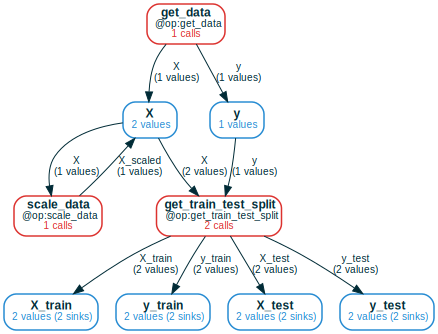

In [4]:
cf = storage.cf(get_train_test_split).expand_back(recursive=True)
cf.draw(verbose=True, orientation='TB')

Note that **the underlying low-level call graph that the CF represents is still
acyclic**, because we distinguish between the value before and after the update.
This shows up in the dataframe representation as two rows, where only one of the
rows contains a call to `scale_data`:

In [5]:
print(cf.df()[['get_data', 'scale_data', 'get_train_test_split']].to_markdown())

|    | get_data                                   | scale_data                                   | get_train_test_split                                   |
|---:|:-------------------------------------------|:---------------------------------------------|:-------------------------------------------------------|
|  0 | Call(get_data, cid='73a...', hid='73a...') | Call(scale_data, cid='09f...', hid='d6b...') | Call(get_train_test_split, cid='3d5...', hid='e0a...') |
|  1 | Call(get_data, cid='73a...', hid='73a...') |                                              | Call(get_train_test_split, cid='119...', hid='7be...') |


### Pipelines that branch and/or merge
Next, lets' train and evaluate two kinds of models: an SVC (support vector
classifier) and a random forest. We then initialize a CF from the `eval_model`
function, and we call `expand_back` to trace back the full computation graph:

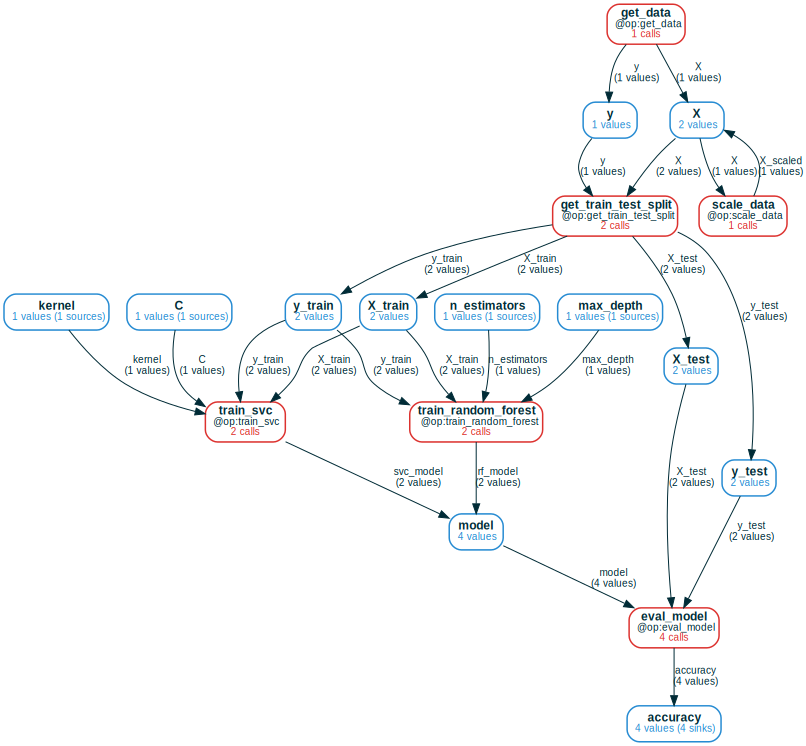

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

@op(output_names=["svc_model"])
def train_svc(X_train, y_train, C: float = 1.0, kernel: str = "linear"):
    model = SVC(C=C, kernel=kernel)
    model.fit(X_train, y_train)
    return model

@op(output_names=["rf_model"])
def train_random_forest(X_train, y_train, n_estimators: int = 5, max_depth: int = 5):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    return model

@op(output_names=["accuracy",])
def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

with storage:
    for scale in (True, False):
        X, y = get_data()
        if scale:
            X = scale_data(X=X)
        X_train, X_test, y_train, y_test = get_train_test_split(X=X, y=y)
        svc_model = train_svc(X_train=X_train, y_train=y_train)
        svc_acc = eval_model(model=svc_model, X_test=X_test, y_test=y_test)
        rf_model = train_random_forest(X_train=X_train, y_train=y_train)
        rf_acc = eval_model(model=rf_model, X_test=X_test, y_test=y_test)

cf = storage.cf(eval_model).expand_back(recursive=True)
cf.draw(verbose=True)

It's quite clear by looking at the CF's drawing what computations we did. As
before, we can obtain a single dataframe that expresses the full computation, 
and we can select operations/variables of interest to analyze the results; for
example, we see that random forest generally performs better than SVC on this
dataset.

In [7]:
print(cf.df()[['accuracy', 'scale_data', 'train_svc', 'train_random_forest']].sort_values('accuracy', ascending=False).to_markdown())

|    |   accuracy | scale_data                                   | train_svc                                   | train_random_forest                                   |
|---:|-----------:|:---------------------------------------------|:--------------------------------------------|:------------------------------------------------------|
|  2 |      0.915 | Call(scale_data, cid='09f...', hid='d6b...') |                                             | Call(train_random_forest, cid='e26...', hid='c42...') |
|  3 |      0.885 |                                              |                                             | Call(train_random_forest, cid='519...', hid='997...') |
|  0 |      0.82  |                                              | Call(train_svc, cid='ddf...', hid='6a0...') |                                                       |
|  1 |      0.82  | Call(scale_data, cid='09f...', hid='d6b...') | Call(train_svc, cid='6f4...', hid='7d9...') |                                           

So is this the full story of this dataset? We might want to investigate further
by 

- training more SVC and random forest models with different hyperparameters;
- ensembling different types of models to see if this improves performance.

We do this below by trying out more kernels for SVC and increasing the number of
trees in the random forest. Importantly, when defining the new `eval_ensemble`
operation, we type-annotate the `models` input using the custom `MList` type
constructor. This is a detail of `mandala`

In [8]:
from typing import Any

@op(output_names=["accuracy"])
def eval_ensemble(models: MList[Any], X_test, y_test):
    y_preds = [model.predict(X_test) for model in models]
    y_pred = np.mean(y_preds, axis=0) > 0.5
    acc = accuracy_score(y_test, y_pred)
    return acc

with storage:
    for scale in (True, False):
        X, y = get_data()
        if scale:
            X = scale_data(X=X)
        X_train, X_test, y_train, y_test = get_train_test_split(X=X, y=y)
        svc_models = []
        for kernel in ('linear', 'rbf', 'poly'):
            svc_model = train_svc(X_train=X_train, y_train=y_train, kernel=kernel)
            svc_acc = eval_model(model=svc_model, X_test=X_test, y_test=y_test)
            svc_models.append(svc_model)
        rf_models = []
        for n_estimators in (5, 10, 20):
            rf_model = train_random_forest(X_train=X_train, y_train=y_train, n_estimators=n_estimators)
            rf_acc = eval_model(model=rf_model, X_test=X_test, y_test=y_test)
            rf_models.append(rf_model)
        
        ensemble_acc = eval_ensemble(models=svc_models + rf_models, X_test=X_test, y_test=y_test)
    

### Tidy tools: merging `ComputationFrame`s

To illustrate how CFs admit **tidy tools** &mdash; operations that take as input
computation frames and produce new ones &mdash; we'll use the `|` operator to
merge the CFs for `eval_model` and `eval_ensemble`. 

Merging is similar to concatenation of dataframes: it takes the union of the
sets of values/calls at each node by matching the names of the operations and
variables between the two CFs. Because both our functions use the same names for
analogous inputs (`X_test` and `y_test`) and outputs (`accuracy`), this works
out nicely: 

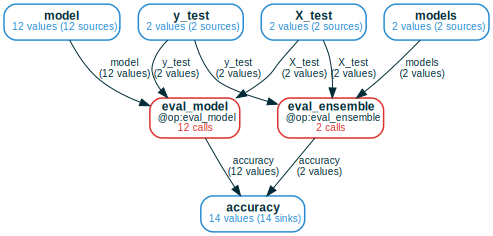

In [9]:
cf = storage.cf(eval_ensemble) | storage.cf(eval_model)
cf.draw(verbose=True)

### Aggregation and/or indexing into data

As before, let's expand this CF back to see the full computation graph that
leads to it:

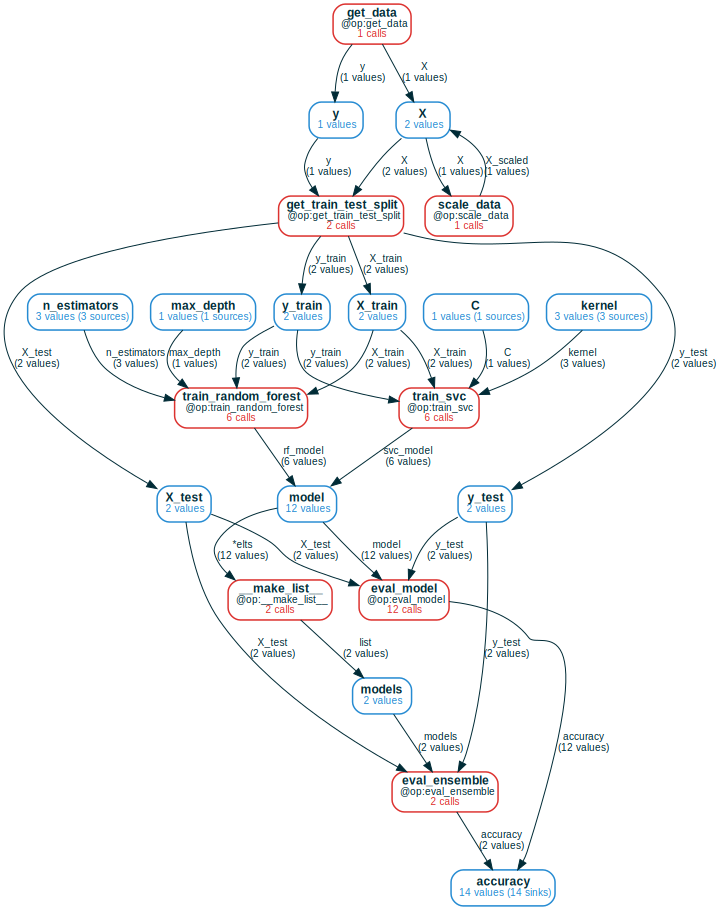

In [10]:
cf = cf.expand_back(recursive=True); cf.draw(verbose=True)

Note the built-in `__make_list__` operation which got automatically
added to the graph. This operation groups the items of the `models` list passed
to `eval_ensemble` into a single object, which is what's actually passed to 
`eval_ensemble` in the expanded graph. `__make_list__` is implemented the same
as any other operation, with (roughly) the following semantics:
```python
@op
def __make_list__(*elts:Any) -> list:
    return list(elts)
```
The "trick" is that all the variadic inputs `elts_0`, `elts_1`, ... are grouped
under the `*elts`-labeled edge, and are found in the `model` variable. This is 
how CFs express the aggregation of multiple values into a single one.

How does `.df()` behave in the presence of such aggregation? We can take a look by
selecting enough columns to paint a complete picture of each branch of the
overall computation:

In [11]:
print(cf.df()[['n_estimators', 'kernel', 'accuracy', ]].sort_values('accuracy', ascending=False).to_markdown())

|    | n_estimators                 | kernel                                     |   accuracy |
|---:|:-----------------------------|:-------------------------------------------|-----------:|
|  2 | 5                            |                                            |      0.915 |
| 11 |                              | rbf                                        |      0.915 |
| 13 |                              | rbf                                        |      0.91  |
|  0 | 10                           |                                            |      0.9   |
|  3 | 10                           |                                            |      0.9   |
|  6 | 20                           |                                            |      0.9   |
|  9 | 20                           |                                            |      0.9   |
|  8 | ValueCollection([20, 10, 5]) | ValueCollection(['linear', 'rbf', 'poly']) |      0.895 |
| 12 | ValueCollection([20, 10, 5]) | Va

Columns where `n_estimators` is `None` correspond to the SVC models, and columns
where `n_estimators` is not `None` correspond to the random forest models. 

But now we also get some columns containing a `ValueCollection` object, which is
the CF's way of distinguishing between depending on a single value of a variable
versus depending on a collection of values. This makes sense: the
`eval_ensemble` calls depend on multiple models, and in turn, on multiple 
values in the `n_estimators` and `kernel` variables.

## Conclusion
The CF visualizations are now getting out of hand, so it's a good time to
wrap up! We've seen how `ComputationFrame`s can be used to represent complex
computations in a tidy way, and how they provide a simple grammar of operations
to manipulate and analyze these computations.

There's much more to `mandala` and `ComputationFrame`s than what we've covered
here. For example, we haven't touched on (even though we did use) the
incremental computation features that `mandala` provides, which allow for
efficient re-computation of only the parts of the computation that have changed.

If you're interested in learning more, check out the [mandala
documentation](https://amakelov.github.io/mandala/), and feel free to reach out
on [Twitter](https://x.com/AMakelov).

## Why "tidy"? And some other related work

### Tidy data vs tidy computations
In many ways, the ideas here are a re-imagining of Hadley Wickham's
[Tidy Data](https://www.jstatsoft.org/article/view/v059i10) in the context of
computational data management. In particular, the focus is on computations built
from repeated calls to the same set of functions composed in various ways, which
is a common pattern in machine learning and scientific computing. And like with
the tidy data philosophy, the goal is to eliminate the code and effort required
to organize computations beyond just running the computation itself.

Despite the different setups &mdash; data cleaning versus computation tracking
&mdash; there are many similarities between the two approaches. This is because
in an abstract sense you can think of "data" as a kind of "computation" that
nature has performed via some "data-generating process". The difference stems
from this process typically being unknown, hidden or otherwise hard to model.
Perhaps this is also why the tidy data paper spends some time talking about notions of functional 
dependencies and normal forms, which are also relevant to computations. In fact,
tidy data is in Codd's third normal form, which is in turn a more relaxed
version of the Boyce-Codd normal form (BCNF). The BCNF is automatically
satisfied by operation nodes in a computation frame when viewed as relations.

On the one hand, the explicit knowledge of the data generating process makes the
job of computation tracking easier in an ontological sense. Wickham remarks
that, while easy to disambiguate in concrete examples, the concepts of
"variable" and "observation" are actually hard to define abstractly. Not so for
computations: variables are inputs/outputs of functions, and observations are
function calls. 

But on the other hand, this detailed knowledge also gives us more complex
situations to handle, such as feedback loops, branching pipelines, and
aggregation/decomposition to name a few. This means we need more expressive
tools and grammars to handle these situations. Furthermore, even if functions
impose a notion of variables and observations, this does not prevent one from
designing function interfaces poorly, which can in turn lead to messy
computations.

### Graphs, databases, categories
There's a rich history of work in relational databases and graph databases, and
CFs share some similarities with both:

- A CF can be seen as a relational database, with a table for each operation and
each variable. The operation tables have columns labeled by the inputs/outputs
of the operation, and the values in these columns are pointers to the
corresponding input/output values, which are stored in the (single-column)
variable tables.
- The `.df()` method works by performing an outer join operation (in a specific
order) on the tables containing the full computational history of all final
values in the CF.
- Similarly, a CF can be seen as a graph database, where the nodes are
calls and values, and the variables and operations serve as "node types".
- Correspondingly, some operations, such as expansion or finding the
dependencies/dependents of some nodes/values can be seen as graph traversal
operations.

Finally, the CF data structure can be seen as a kind of "functor" from a finite
category (roughly speaking the call graph) to the category of sets. Some
consequences of this perspective &mdash; which combines graphs and databases
&mdash; are presented e.g. in [this
paper](https://compositionality-journal.org/papers/compositionality-4-5/)